<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/07_pytorch_experiment_tracking_exercise_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07. PyTorch Experiment Tracking Exercise Solutions

Welcome to the 07. PyTorch Experiment Tracking exercise solutions notebook.

> **Note:** There may be more than one solution to each of the exercises. This notebook only shows one possible example.

## Resources

1. These exercises/solutions are based on [section 07. PyTorch Transfer Learning](https://www.learnpytorch.io/07_pytorch_experiment_tracking/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/cO_r2FYcAjU).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

### Get various imports and helper functions

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
import torch
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")


torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
# Make sure we have a GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [3]:
# Get regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms


from torchinfo import summary

from going_modular.going_modular import data_setup, engine


In [4]:
# Getting setup
import torch
import torchvision

# This notebook requires torch v0.12+ and torchvision v0.13+
print(torch.__version__)
print(torchvision.__version__)


2.0.1+cu118
0.15.2+cu118


In [5]:
# Set seeds
def set_seeds(seed: int = 42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)


In [6]:
import os
import zipfile

from pathlib import Path

import requests


def download_data(source: str, destination: str, remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path


image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi",
)
image_path


[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [7]:
from torch.utils.tensorboard import SummaryWriter


def create_writer(experiment_name: str, model_name: str, extra: str = None):
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d")  # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)


In [8]:
# Create a test writer
writer = create_writer(
    experiment_name="test_experiment_name",
    model_name="this_is_the_model_name",
    extra="add_a_little_extra_if_you_want",
)


[INFO] Created SummaryWriter, saving to: runs\2023-05-18\test_experiment_name\this_is_the_model_name\add_a_little_extra_if_you_want...


In [9]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step


# Add writer parameter to train()
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
    writer: torch.utils.tensorboard.writer.SummaryWriter,  # new parameter to take in a writer
) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]}
      For example if training for epochs=2:
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        test_loss, test_acc = test_step(
            model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device
        )

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(
                main_tag="Loss",
                tag_scalar_dict={"train_loss": train_loss, "test_loss": test_loss},
                global_step=epoch,
            )
            writer.add_scalars(
                main_tag="Accuracy",
                tag_scalar_dict={"train_acc": train_acc, "test_acc": test_acc},
                global_step=epoch,
            )

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results


### Download data

Using the same data from https://www.learnpytorch.io/07_pytorch_experiment_tracking/

In [10]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi",
)

data_20_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination="pizza_steak_sushi_20_percent",
)


[INFO] data\pizza_steak_sushi directory exists, skipping download.
[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


In [11]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")


Training directory 10%: data\pizza_steak_sushi\train
Training directory 20%: data\pizza_steak_sushi_20_percent\train
Testing directory: data\pizza_steak_sushi\test


In [12]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],  # values per colour channel [red, green, blue]
    std=[0.229, 0.224, 0.225],
)

# Create a transform pipeline
simple_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),  # get image values between 0 & 1
        normalize,
    ]
)


### Turn data into DataLoaders 

In [13]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_10_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE,
)

# Create 20% training and test DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE,
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(
    f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}"
)
print(
    f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}"
)
print(
    f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)"
)
print(f"Number of classes: {len(class_names)}, class names: {class_names}")


Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


## Exercise 1: Pick a larger model from [`torchvision.models`](https://pytorch.org/vision/main/models.html) to add to the list of experiments (for example, EffNetB3 or higher)

* How does it perform compared to our existing models?

In notebook 07, we tried out EffNetB0 and EffNetB2 with ~4M parameters and ~9M parameters respectively, let's try step things up by using a bigger model.

Let's try EfficientNet_V2_S (efficientnet version 2 small, EffNetV2_S for short) which has ~20M parameters - https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_v2_s.html#torchvision.models.EfficientNet_V2_S_Weights 

To keep things simple, let's just compare EffNetB2 (best performing model) to EffNetV2_S

### Create models

In [14]:
import torchvision.models as models

effnetv2_s_weights = models.EfficientNet_V2_S_Weights.DEFAULT  # .DEFAULT = "best available weights"
effnetv2_s = models.efficientnet_v2_s(weights=effnetv2_s_weights)
# effnetv2_s


In [15]:
def create_effnetb2(out_features=len(class_names)):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    dropout = 0.3
    in_features = 1408

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Set the seeds
    set_seeds()

    # Update the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout, inplace=True),
        nn.Linear(in_features=in_features, out_features=out_features),
    ).to(device)

    # Set the model name
    model.name = "effnetb2"
    print(f"[INFO] Creating {model.name} feature extractor model...")
    return model


def create_effnetv2_s(out_features=len(class_names)):
    weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
    model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)
    dropout = 0.2
    in_features = 1280

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Set the seeds
    set_seeds()

    # Update the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout, inplace=True),
        nn.Linear(in_features=in_features, out_features=out_features),
    ).to(device)

    # Set the model name
    model.name = "effnetv2_s"
    print(f"[INFO] Creating {model.name} feature extractor model...")
    return model


### Setup modelling experiments

Going to use similar code to: https://www.learnpytorch.io/07_pytorch_experiment_tracking/#76-create-experiments-and-set-up-training-code 

For our modelling experiments, mainly want to substitude EffNetB0 experiments with EffNetV2_S in its place.

In [16]:
# Create epoch list
num_epochs = [5, 10]

# Create models list
models = ["effnetb2", "effnetv2_s"]

# Create dataloaders dictionary for various dataloaders
train_dataloaders = {
    "data_10_percent": train_dataloader_10_percent,
    "data_20_percent": train_dataloader_20_percent,
}


In [17]:
%%time
from going_modular.going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
    # 4. Loop through each number of epochs
    for epochs in num_epochs:
        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:
            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")

            # 7. Select the model
            if model_name == "effnetb2":
                model = create_effnetb2()
            else:
                model = create_effnetv2_s()

            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(
                model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                writer=create_writer(
                    experiment_name=dataloader_name, model_name=model_name, extra=f"{epochs}_epochs"
                ),
            )

            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model, target_dir="models", model_name=save_filepath)
            print("-" * 50 + "\n")


[INFO] Experiment number: 1
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Creating effnetb2 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs\2023-05-18\data_10_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3750 | test_loss: 0.9647 | test_acc: 0.6297
Epoch: 2 | train_loss: 0.9354 | train_acc: 0.6289 | test_loss: 0.8762 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8320 | train_acc: 0.7422 | test_loss: 0.7536 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.7111 | train_acc: 0.8828 | test_loss: 0.7197 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6882 | train_acc: 0.7969 | test_loss: 0.7140 | test_acc: 0.8769
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetv2_s
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Creating effnetv2_s feature extractor model...
[INFO] Created SummaryWriter, saving to: runs\2023-05-18\data_10_percent\effnetv2_s\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0740 | train_acc: 0.2930 | test_loss: 0.9119 | test_acc: 0.7831
Epoch: 2 | train_loss: 0.9056 | train_acc: 0.6992 | test_loss: 0.8713 | test_acc: 0.7131
Epoch: 3 | train_loss: 0.8559 | train_acc: 0.6406 | test_loss: 0.7642 | test_acc: 0.7652
Epoch: 4 | train_loss: 0.7326 | train_acc: 0.7617 | test_loss: 0.6259 | test_acc: 0.9271
Epoch: 5 | train_loss: 0.6821 | train_acc: 0.8438 | test_loss: 0.6200 | test_acc: 0.8759
[INFO] Saving model to: models\07_effnetv2_s_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Creating effnetb2 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs\2023-05-18\data_10_percent\effnetb2\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3750 | test_loss: 0.9647 | test_acc: 0.6297
Epoch: 2 | train_loss: 0.9354 | train_acc: 0.6289 | test_loss: 0.8762 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8320 | train_acc: 0.7422 | test_loss: 0.7536 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.7111 | train_acc: 0.8828 | test_loss: 0.7197 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6882 | train_acc: 0.7969 | test_loss: 0.7140 | test_acc: 0.8769
Epoch: 6 | train_loss: 0.6003 | train_acc: 0.9102 | test_loss: 0.6395 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.5842 | train_acc: 0.8086 | test_loss: 0.6438 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.5232 | train_acc: 0.9258 | test_loss: 0.6251 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5364 | train_acc: 0.8125 | test_loss: 0.6314 | test_acc: 0.8466
Epoch: 10 | train_loss: 0.4981 | train_acc: 0.9141 | test_loss: 0.5871 | test_acc: 0.8873
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0740 | train_acc: 0.2930 | test_loss: 0.9119 | test_acc: 0.7831
Epoch: 2 | train_loss: 0.9056 | train_acc: 0.6992 | test_loss: 0.8713 | test_acc: 0.7131
Epoch: 3 | train_loss: 0.8559 | train_acc: 0.6406 | test_loss: 0.7642 | test_acc: 0.7652
Epoch: 4 | train_loss: 0.7326 | train_acc: 0.7617 | test_loss: 0.6259 | test_acc: 0.9271
Epoch: 5 | train_loss: 0.6821 | train_acc: 0.8438 | test_loss: 0.6200 | test_acc: 0.8759
Epoch: 6 | train_loss: 0.6041 | train_acc: 0.8789 | test_loss: 0.6244 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.6315 | train_acc: 0.7539 | test_loss: 0.5642 | test_acc: 0.8968
Epoch: 8 | train_loss: 0.5364 | train_acc: 0.9102 | test_loss: 0.5206 | test_acc: 0.8864
Epoch: 9 | train_loss: 0.5805 | train_acc: 0.7539 | test_loss: 0.5202 | test_acc: 0.8153
Epoch: 10 | train_loss: 0.5162 | train_acc: 0.8086 | test_loss: 0.4968 | test_acc: 0.8759
[INFO] Saving model to: models\07_effnetv2_s_data_10_percent_10_epochs.pth
----------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9915 | train_acc: 0.5208 | test_loss: 0.7871 | test_acc: 0.7945
Epoch: 2 | train_loss: 0.7381 | train_acc: 0.7542 | test_loss: 0.6702 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.6063 | train_acc: 0.8313 | test_loss: 0.5717 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5345 | train_acc: 0.8396 | test_loss: 0.5769 | test_acc: 0.8163
Epoch: 5 | train_loss: 0.4323 | train_acc: 0.8771 | test_loss: 0.4504 | test_acc: 0.9384
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetv2_s
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Creating effnetv2_s feature extractor model...
[INFO] Created SummaryWriter, saving to: runs\2023-05-18\data_20_percent\effnetv2_s\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9782 | train_acc: 0.5792 | test_loss: 0.7433 | test_acc: 0.8864
Epoch: 2 | train_loss: 0.7236 | train_acc: 0.7917 | test_loss: 0.6367 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.6272 | train_acc: 0.7979 | test_loss: 0.5213 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.5525 | train_acc: 0.8354 | test_loss: 0.4902 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5412 | train_acc: 0.8063 | test_loss: 0.4234 | test_acc: 0.8769
[INFO] Saving model to: models\07_effnetv2_s_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Creating effnetb2 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs\2023-05-18\data_20_percent\effnetb2\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9915 | train_acc: 0.5208 | test_loss: 0.7871 | test_acc: 0.7945
Epoch: 2 | train_loss: 0.7381 | train_acc: 0.7542 | test_loss: 0.6702 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.6063 | train_acc: 0.8313 | test_loss: 0.5717 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5345 | train_acc: 0.8396 | test_loss: 0.5769 | test_acc: 0.8163
Epoch: 5 | train_loss: 0.4323 | train_acc: 0.8771 | test_loss: 0.4504 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.3837 | train_acc: 0.9062 | test_loss: 0.4619 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3661 | train_acc: 0.9083 | test_loss: 0.4232 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3827 | train_acc: 0.8938 | test_loss: 0.4398 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.3301 | train_acc: 0.9333 | test_loss: 0.4312 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.3720 | train_acc: 0.9042 | test_loss: 0.3918 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9782 | train_acc: 0.5792 | test_loss: 0.7433 | test_acc: 0.8864
Epoch: 2 | train_loss: 0.7236 | train_acc: 0.7917 | test_loss: 0.6367 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.6272 | train_acc: 0.7979 | test_loss: 0.5213 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.5525 | train_acc: 0.8354 | test_loss: 0.4902 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5412 | train_acc: 0.8063 | test_loss: 0.4234 | test_acc: 0.8769
Epoch: 6 | train_loss: 0.4454 | train_acc: 0.8562 | test_loss: 0.4098 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.4437 | train_acc: 0.8438 | test_loss: 0.3870 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.3977 | train_acc: 0.8688 | test_loss: 0.4008 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.3708 | train_acc: 0.8875 | test_loss: 0.3965 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.3964 | train_acc: 0.8604 | test_loss: 0.3396 | test_acc: 0.9271
[INFO] Saving model to: models\07_effnetv2_s_data_20_percent_10_epochs.pth
----------------------------------

## Exercise 2. Introduce data augmentation to the list of experiments using the 20% pizza, steak, sushi training and test datasets, does this change anything?
    
* For example, you could have one training DataLoader that uses data augmentation (e.g. `train_dataloader_20_percent_aug` and `train_dataloader_20_percent_no_aug`) and then compare the results of two of the same model types training on these two DataLoaders.
* **Note:** You may need to alter the `create_dataloaders()` function to be able to take a transform for the training data and the testing data (because you don't need to perform data augmentation on the test data). See [04. PyTorch Custom Datasets section 6](https://www.learnpytorch.io/04_pytorch_custom_datasets/#6-other-forms-of-transforms-data-augmentation) for examples of using data augmentation or the script below for an example:

```python
# Note: Data augmentation transform like this should only be performed on training data
train_transform_data_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

# Have to update `create_dataloaders()` to handle different augmentations
import os
from torch.utils.data import DataLoader
from torchvision import datasets

NUM_WORKERS = os.cpu_count() # use maximum number of CPUs for workers to load data 

# Note: this is an update version of data_setup.create_dataloaders to handle
# differnt train and test transforms.
def create_dataloaders(
    train_dir, 
    test_dir, 
    train_transform, # add parameter for train transform (transforms on train dataset)
    test_transform,  # add parameter for test transform (transforms on test dataset)
    batch_size=32, num_workers=NUM_WORKERS
):
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names
```

### Create data augmentation and non-data augmentation transforms 

What we want now:
* 2x different training dataloaders:
  1. A 20% DataLoader *with* augmentation (let's use https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html)
  2. A 20% Dataloader *without* augmentation
* Use EffNetV2_s model
* Train for 5 and 10 epochs

In [18]:
# Create a data augmentation transfrom
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],  # values per colour channel [red, green, blue]
    std=[0.229, 0.224, 0.225],
)

data_aug_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        normalize,
    ]
)

# Create a non-data aug transform
no_data_aug_transform = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor(), normalize]
)


### Alter `data_setup.create_dataloaders()` to work with multiple transforms

In [19]:
# Create dataloaders, let's do this by updating data_setup.create_dataloaders()
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = 0


def create_dataloaders(
    train_dir: str,
    test_dir: str,
    train_transform: transforms.Compose,  ### New (only want to do data augmentation on the training dataset)
    test_transform: transforms.Compose,  ### New
    batch_size: int,
    num_workers: int = NUM_WORKERS,
):
    """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)  ### New
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)  ### New

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names


In [20]:
# Create train and test directories
train_20_percent_dir = image_path / "train"
test_20_percent_dir = image_path / "test"

BATCH_SIZE = 32

# Create train dataloader *with* data augmentation
train_dataloader_20_percent_with_aug, test_dataloader_20_percent, class_names = create_dataloaders(
    train_dir=train_20_percent_dir,
    test_dir=test_20_percent_dir,
    train_transform=data_aug_transform,
    test_transform=no_data_aug_transform,
    batch_size=BATCH_SIZE,
)

# Create train dataloader *without* data augmentation
(
    train_dataloader_20_percent_without_aug,
    test_dataloader_20_percent,
    class_names,
) = create_dataloaders(
    train_dir=train_20_percent_dir,
    test_dir=test_20_percent_dir,
    train_transform=no_data_aug_transform,
    test_transform=no_data_aug_transform,
    batch_size=BATCH_SIZE,
)


### Create a helper function for viewing different DataLoader images

In [21]:
# Visulize different samples from both dataloaders (aug and no aug)
def view_dataloader_images(dataloader, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min) / (sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, 10, i + 1)
        plt.imshow(sample_scaled.permute(1, 2, 0))  # resize for Matplotlib requirements
        plt.title(class_names[labels[i]])
        plt.axis(False)


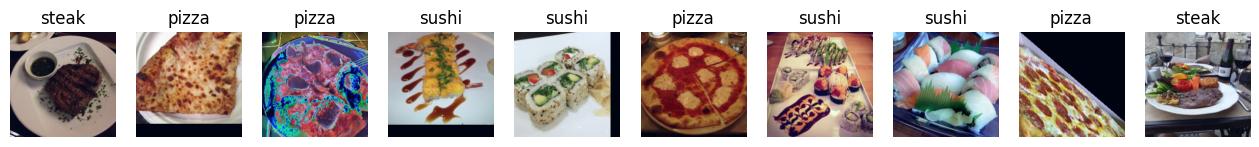

In [22]:
# Check out samples with data augmentation
view_dataloader_images(train_dataloader_20_percent_with_aug)


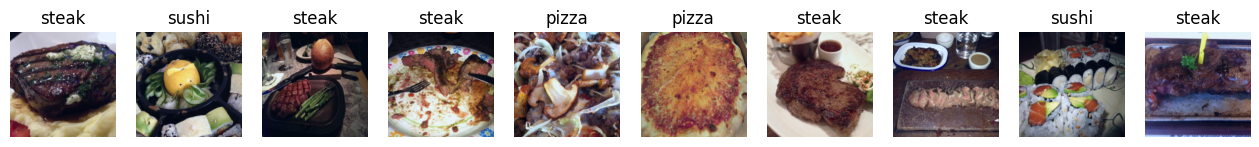

In [23]:
# Checkout samples without data augmentation
view_dataloader_images(train_dataloader_20_percent_without_aug)


### Run data aug vs no data aug experiments

In [24]:
# Setup number of epochs
num_epochs = [5, 10]

# Create dataloaders dictionary for various dataloaders
train_dataloaders = {
    "data_20_percent_with_aug": train_dataloader_20_percent_with_aug,
    "data_20_percent_without_aug": train_dataloader_20_percent_without_aug,
}

# Create model
models = ["effnetv2_s"]


In [25]:
%%time
from going_modular.going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
    # 4. Loop through each number of epochs
    for epochs in num_epochs:
        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:
            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")

            # 7. Select the model
            if model_name == "effnetb2":
                model = create_effnetb2()
            else:
                model = create_effnetv2_s()

            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(
                model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader_20_percent,  ### New, use test_dataloader_20_percent
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                writer=create_writer(
                    experiment_name=dataloader_name, model_name=model_name, extra=f"{epochs}_epochs"
                ),
            )

            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model, target_dir="models", model_name=save_filepath)
            print("-" * 50 + "\n")


[INFO] Experiment number: 1
[INFO] Model: effnetv2_s
[INFO] DataLoader: data_20_percent_with_aug
[INFO] Number of epochs: 5
[INFO] Creating effnetv2_s feature extractor model...
[INFO] Created SummaryWriter, saving to: runs\2023-05-18\data_20_percent_with_aug\effnetv2_s\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0701 | train_acc: 0.3477 | test_loss: 0.8938 | test_acc: 0.7017
Epoch: 2 | train_loss: 0.9859 | train_acc: 0.5430 | test_loss: 0.8188 | test_acc: 0.7642
Epoch: 3 | train_loss: 0.8615 | train_acc: 0.6758 | test_loss: 0.7432 | test_acc: 0.8153
Epoch: 4 | train_loss: 0.7939 | train_acc: 0.8438 | test_loss: 0.6616 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.7301 | train_acc: 0.7148 | test_loss: 0.5675 | test_acc: 0.9167
[INFO] Saving model to: models\07_effnetv2_s_data_20_percent_with_aug_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetv2_s
[INFO] DataLoader: data_20_percent_with_aug
[INFO] Number of epochs: 10
[INFO] Creating effnetv2_s feature extractor model...
[INFO] Created SummaryWriter, saving to: runs\2023-05-18\data_20_percent_with_aug\effnetv2_s\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0701 | train_acc: 0.3477 | test_loss: 0.8938 | test_acc: 0.7017
Epoch: 2 | train_loss: 0.9859 | train_acc: 0.5430 | test_loss: 0.8188 | test_acc: 0.7642
Epoch: 3 | train_loss: 0.8615 | train_acc: 0.6758 | test_loss: 0.7432 | test_acc: 0.8153
Epoch: 4 | train_loss: 0.7939 | train_acc: 0.8438 | test_loss: 0.6616 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.7301 | train_acc: 0.7148 | test_loss: 0.5675 | test_acc: 0.9167
Epoch: 6 | train_loss: 0.6741 | train_acc: 0.7266 | test_loss: 0.5806 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.6724 | train_acc: 0.7461 | test_loss: 0.5794 | test_acc: 0.8456
Epoch: 8 | train_loss: 0.6013 | train_acc: 0.8633 | test_loss: 0.5814 | test_acc: 0.8456
Epoch: 9 | train_loss: 0.6427 | train_acc: 0.7305 | test_loss: 0.5304 | test_acc: 0.8352
Epoch: 10 | train_loss: 0.5952 | train_acc: 0.7578 | test_loss: 0.4707 | test_acc: 0.8456
[INFO] Saving model to: models\07_effnetv2_s_data_20_percent_with_aug_10_epochs.pth
-------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0740 | train_acc: 0.2930 | test_loss: 0.9119 | test_acc: 0.7831
Epoch: 2 | train_loss: 0.9056 | train_acc: 0.6992 | test_loss: 0.8713 | test_acc: 0.7131
Epoch: 3 | train_loss: 0.8559 | train_acc: 0.6406 | test_loss: 0.7642 | test_acc: 0.7652
Epoch: 4 | train_loss: 0.7326 | train_acc: 0.7617 | test_loss: 0.6259 | test_acc: 0.9271
Epoch: 5 | train_loss: 0.6821 | train_acc: 0.8438 | test_loss: 0.6200 | test_acc: 0.8759
[INFO] Saving model to: models\07_effnetv2_s_data_20_percent_without_aug_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetv2_s
[INFO] DataLoader: data_20_percent_without_aug
[INFO] Number of epochs: 10
[INFO] Creating effnetv2_s feature extractor model...
[INFO] Created SummaryWriter, saving to: runs\2023-05-18\data_20_percent_without_aug\effnetv2_s\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0740 | train_acc: 0.2930 | test_loss: 0.9119 | test_acc: 0.7831
Epoch: 2 | train_loss: 0.9056 | train_acc: 0.6992 | test_loss: 0.8713 | test_acc: 0.7131
Epoch: 3 | train_loss: 0.8559 | train_acc: 0.6406 | test_loss: 0.7642 | test_acc: 0.7652
Epoch: 4 | train_loss: 0.7326 | train_acc: 0.7617 | test_loss: 0.6259 | test_acc: 0.9271
Epoch: 5 | train_loss: 0.6821 | train_acc: 0.8438 | test_loss: 0.6200 | test_acc: 0.8759
Epoch: 6 | train_loss: 0.6041 | train_acc: 0.8789 | test_loss: 0.6244 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.6315 | train_acc: 0.7539 | test_loss: 0.5642 | test_acc: 0.8968
Epoch: 8 | train_loss: 0.5364 | train_acc: 0.9102 | test_loss: 0.5206 | test_acc: 0.8864
Epoch: 9 | train_loss: 0.5805 | train_acc: 0.7539 | test_loss: 0.5202 | test_acc: 0.8153
Epoch: 10 | train_loss: 0.5162 | train_acc: 0.8086 | test_loss: 0.4968 | test_acc: 0.8759
[INFO] Saving model to: models\07_effnetv2_s_data_20_percent_without_aug_10_epochs.pth
----------------------

## Exercise 3. Scale up the dataset to turn FoodVision Mini into FoodVision Big using the entire [Food101 dataset from `torchvision.models`](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101)
    
* You could take the best performing model from your various experiments or even the EffNetB2 feature extractor we created in this notebook and see how it goes fitting for 5 epochs on all of Food101.
* If you try more than one model, it would be good to have the model's results tracked.
* If you load the Food101 dataset from `torchvision.models`, you'll have to create PyTorch DataLoaders to use it in training.
* **Note:** Due to the larger amount of data in Food101 compared to our pizza, steak, sushi dataset, this model will take longer to train.

We've got a model that's working (EffNetV2_S) pretty well.

So now let's turn our FoodVision Mini model into FoodVision BIG by upscaling the data.

Specifically, let's train a EffNetV2_S feature extractor on all of the Food101 data.

We'll do so for 5 epochs without data augmentation.

### Download Food101 Dataset

In [26]:
# Get Food101 Dataset
import torchvision
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],  # values per colour channel [red, green, blue]
    std=[0.229, 0.224, 0.225],
)

# Create a transform pipeline
simple_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),  # get image values between 0 & 1
        normalize,
    ]
)

# Download and transform Food101 data (note: this may take ~5 minutes in Google Colab)
train_data = torchvision.datasets.Food101(
    root="data", split="train", transform=simple_transform, download=True
)

test_data = torchvision.datasets.Food101(
    root="data", split="test", transform=simple_transform, download=True
)


Using downloaded and verified file: data\food-101.tar.gz
Extracting data\food-101.tar.gz to data


In [27]:
# Check sample numbers
len(train_data), len(test_data)


(75750, 25250)

### Create Food101 DataLoaders

In [28]:
# Create DataLoaders
import os

BATCH_SIZE = 512  # use a big batch size to get through all the images (100,000+ in Food101)

train_dataloader_big = torch.utils.data.DataLoader(
    train_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True
)  # avoid copies of the data into and out of memory, where possible (for speed ups)

test_dataloader_big = torch.utils.data.DataLoader(
    test_data, shuffle=False, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True
)


### Create FoodVision Big model and train it

In [30]:
# Create model
effnetv2_s_weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
foodvision_big_model = torchvision.models.efficientnet_v2_s(weights=effnetv2_s_weights).to(device)

# Freeze the base layers
for param in foodvision_big_model.features.parameters():
    param.requires_grad = False

# Change the classifier head to suit 101 different classes
foodvision_big_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280, out_features=101),  # 101 output classes for Food101
).to(device)

# summary(model=foodvision_big_model,
#         input_size=(1, 3, 224, 224))


In [31]:
foodvision_big_results = train(
    model=foodvision_big_model,
    train_dataloader=train_dataloader_big,
    test_dataloader=test_dataloader_big,
    optimizer=torch.optim.Adam(params=foodvision_big_model.parameters(), lr=0.001),
    loss_fn=torch.nn.CrossEntropyLoss(),
    epochs=5,
    device=device,
    writer=create_writer(
        experiment_name="food101_all_data", model_name="foodvision_big", extra=f"{epochs}_epochs"
    ),
)


[INFO] Created SummaryWriter, saving to: runs\2023-05-19\food101_all_data\foodvision_big\10_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4601 | train_acc: 0.2852 | test_loss: 2.6101 | test_acc: 0.4329
Epoch: 2 | train_loss: 2.6064 | train_acc: 0.4061 | test_loss: 2.2402 | test_acc: 0.4754
Epoch: 3 | train_loss: 2.3918 | train_acc: 0.4372 | test_loss: 2.1030 | test_acc: 0.4962
Epoch: 4 | train_loss: 2.2854 | train_acc: 0.4523 | test_loss: 2.0276 | test_acc: 0.5074
Epoch: 5 | train_loss: 2.2158 | train_acc: 0.4646 | test_loss: 1.9771 | test_acc: 0.5125
